In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
class Julia_problem:
    def __init__(self, max_scale, resolution, max_iter, c) -> None:
        self.max_scale = max_scale
        self.resolution = resolution
        self.max_iter = max_iter
        self.c = c
        self.restart()

    def restart(self):
        self.x, self.y = np.meshgrid(
            np.linspace(
                -self.max_scale, self.max_scale, self.resolution
            ),  # float by default
            np.linspace(
                -self.max_scale, self.max_scale, self.resolution
            ),  # float by default
        )


def solve_Julia_numpy(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        z_arr[is_converging] = z_arr[is_converging] ** 2 + c
        is_diverged_now = (z_arr * np.conj(z_arr) > 4) & (is_converging)
        iter_til_conv[is_diverged_now] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)


@njit("	i2[:,:](f8[:,:], f8[:,:], i8, c8)")
def solve_Julia_numba(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_converging[row, col]:
                    z_arr[row, col] = z_arr[row, col] ** 2 + c

        is_diverged_now = (np.abs(z_arr) > 2) & (is_converging)

        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_diverged_now[row, col]:
                    iter_til_conv[row, col] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)


def plot_julia_img(ax, iter_til_conv, max_scale):
    ax.imshow(
        iter_til_conv,
        cmap="gray",
        extent=[-max_scale, max_scale, -max_scale, max_scale],
    )


def do_experimet(problem: Julia_problem, n, solver):
    # warm start  for compilation
    solver(problem.x, problem.y, problem.max_iter, problem.c)

    start = time.perf_counter()
    for _ in range(n):
        solver(problem.x, problem.y, problem.max_iter, problem.c)
    end = time.perf_counter()
    return (end - start) / n

In [3]:
max_scale = 1.5
problem = Julia_problem(max_scale, 500, 255, c=1 - 1.68)
type(problem.x)

numpy.ndarray

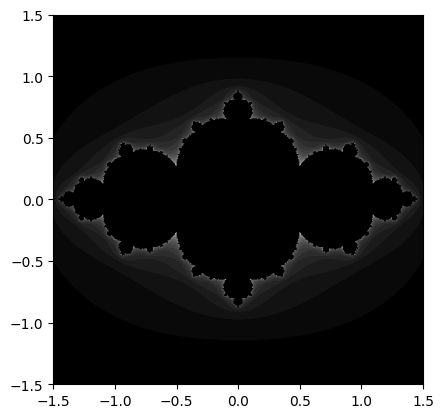

In [4]:
solution = solve_Julia_numba(problem.x, problem.y, problem.max_iter, problem.c)
fig, ax = plt.subplots(1, 1)
plot_julia_img(ax, solution, max_scale)

Add the same function but with different numba options

In [5]:
@njit(fastmath=True)
def solve_Julia_numba_fmT(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_converging[row, col]:
                    z_arr[row, col] = z_arr[row, col] ** 2 + c

        is_diverged_now = (np.abs(z_arr) > 2) & (is_converging)

        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_diverged_now[row, col]:
                    iter_til_conv[row, col] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)


@njit(fastmath=False)
def solve_Julia_numba_fmF(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_converging[row, col]:
                    z_arr[row, col] = z_arr[row, col] ** 2 + c

        is_diverged_now = (np.abs(z_arr) > 2) & (is_converging)

        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_diverged_now[row, col]:
                    iter_til_conv[row, col] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)


@njit(parallel=True, fastmath=True)
def solve_Julia_numba_FmT_parT(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_converging[row, col]:
                    z_arr[row, col] = z_arr[row, col] ** 2 + c

        is_diverged_now = (np.abs(z_arr) > 2) & (is_converging)

        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_diverged_now[row, col]:
                    iter_til_conv[row, col] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)


@njit(parallel=True, fastmath=False)
def solve_Julia_numba_FmF_parT(x, y, max_iter, c):
    z_arr = x + y * 1j
    old_shape = z_arr.shape
    iter_til_conv = np.zeros(shape=old_shape, dtype=np.int16)
    is_converging = np.ones(shape=old_shape, dtype=np.bool_)

    ### make evolution of those who is_converging and update counter
    for i in range(max_iter):
        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_converging[row, col]:
                    z_arr[row, col] = z_arr[row, col] ** 2 + c

        is_diverged_now = (np.abs(z_arr) > 2) & (is_converging)

        for row in range(old_shape[0]):
            for col in range(old_shape[1]):
                if is_diverged_now[row, col]:
                    iter_til_conv[row, col] = i
        is_converging = is_converging & ~(is_diverged_now)

    return iter_til_conv.reshape(old_shape)

In [6]:
def do_seq_experiments(observations, problem):
    N = 3

    np_time = do_experimet(problem, n=N, solver=solve_Julia_numpy)
    fmT = do_experimet(problem, n=N, solver=solve_Julia_numba_fmT)
    fmF = do_experimet(problem, n=N, solver=solve_Julia_numba_fmF)
    FmF_parT = do_experimet(problem, n=N, solver=solve_Julia_numba_FmF_parT)
    FmT_parT = do_experimet(problem, n=N, solver=solve_Julia_numba_FmT_parT)

    obs = pd.Series(
        {
            "numba fastmath=True": fmT,
            "numba fastmath=False": fmF,
            "numba fastmath=False parallel=True": FmF_parT,
            "numba fastmath=True parallel=True": FmT_parT,
            "numpy": np_time,
        },
    )
    observations.loc[problem.resolution] = obs
    return observations

In [7]:
observations = pd.DataFrame(
    columns=[
        "resolution",
        "numba fastmath=True",
        "numba fastmath=False",
        "numba fastmath=True parallel=True",
        "numba fastmath=False parallel=True",
        "numpy",
    ]
).set_index("resolution")

for resolution in [300, 500, 600, 700, 800]:
    problem = Julia_problem(max_scale, resolution, 255, c=1 - 1.68)
    do_seq_experiments(observations, problem)

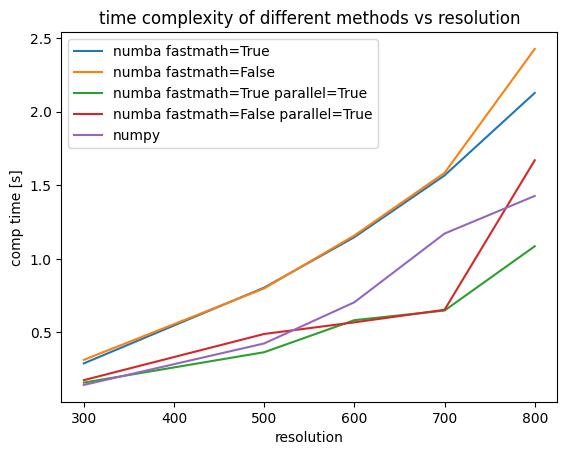

In [8]:
observations.plot(
    ylabel="comp time [s]", title="time complexity of different methods vs resolution"
)
plt.show()